### Average ellipticity as an estimator for shear in DC2

In this notebook, we assess whether the average ellipticity of neighboring galaxies is a reasonable baseline estimator for the average shear in a tile.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

---

First, we'll do some exploratory analysis of shear and ellipticity.

We unpack the `from_file` method of `LensingDC2Catalog` (which can be found in `lensing_dc2.py`) to read in a DC2 catalog and convert unlensed ellipticites to lensed ellipticities. We use the same calculation as [this notebook](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/matching_fof.ipynb).

In [2]:
catalog_full = pd.read_pickle('/data/scratch/dc2local/dc2_lensing_catalog.pkl')

In [3]:
# for computational efficiency, we use a subset of the above data frame
catalog = catalog_full.sample(n = 100000)

In [4]:
galid = torch.from_numpy(catalog["galaxy_id"].values)
ra = torch.from_numpy(catalog["ra"].values).squeeze()
dec = torch.from_numpy(catalog["dec"].values).squeeze()

shear1 = torch.from_numpy(catalog["shear_1"].values).squeeze()
shear2 = torch.from_numpy(catalog["shear_2"].values).squeeze()
convergence = torch.from_numpy(catalog["convergence"].values)

ellip1_intrinsic = torch.from_numpy(catalog["ellipticity_1_true_dc2"].values).squeeze()
ellip2_intrinsic = torch.from_numpy(catalog["ellipticity_2_true_dc2"].values).squeeze()
ellip_intrinsic = torch.sqrt(ellip1_intrinsic ** 2 + ellip2_intrinsic ** 2)

complex_shear = shear1 + shear2 * 1j
complex_ellip = ellip1_intrinsic + ellip2_intrinsic * 1j
reduced_shear = complex_shear / (1.0 - convergence)
ellip_lensed = (complex_ellip + reduced_shear) / (1.0 + reduced_shear.conj() * complex_ellip)
ellip1_lensed = torch.view_as_real(ellip_lensed)[...,0]
ellip2_lensed = torch.view_as_real(ellip_lensed)[...,1]
ellip_lensed = torch.absolute(ellip_lensed)

We see that shear1 and shear2 are each approximately $\mathcal{N}(0, 0.015^2)$, and that they are essentially uncorrelated:

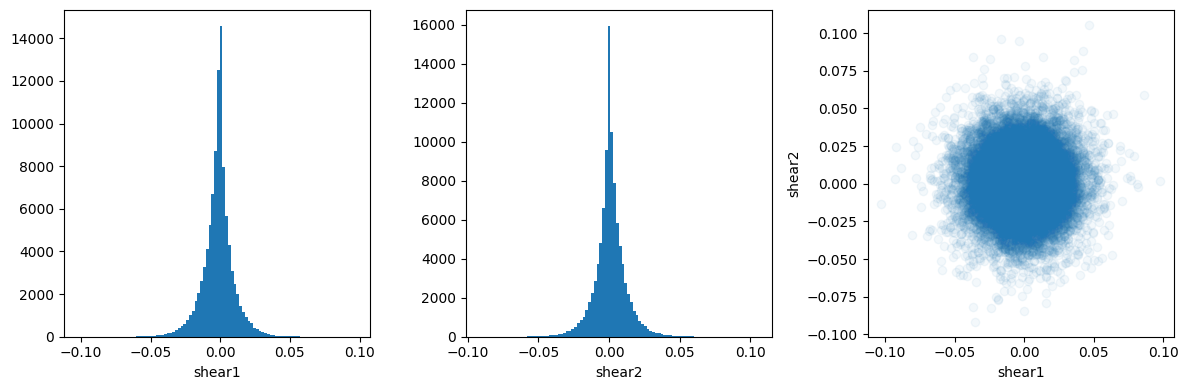

In [5]:
fig, ax = plt.subplots(1, 3, figsize = (12,4))
_ = ax[0].hist(shear1, bins = 100)
_ = ax[0].set_xlabel('shear1')
_ = ax[1].hist(shear2, bins = 100)
_ = ax[1].set_xlabel('shear2')
_ = ax[2].scatter(shear1, shear2, alpha = 0.05)
_ = ax[2].set_xlabel('shear1')
_ = ax[2].set_ylabel('shear2')
fig.tight_layout()

And we find that the two components of lensed ellipticity are each symmetrically distributed around zero, and that they are uncorrelated:

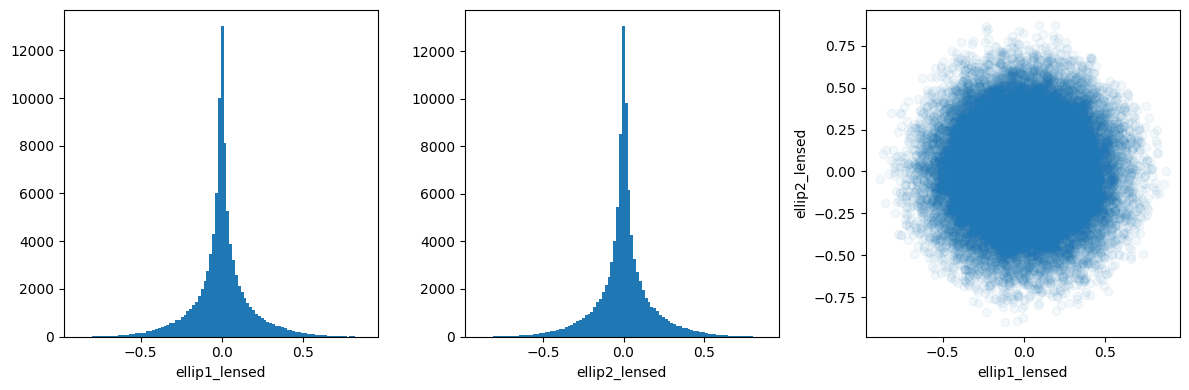

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (12,4))
_ = ax[0].hist(ellip1_lensed, bins = 100)
_ = ax[0].set_xlabel('ellip1_lensed')
_ = ax[1].hist(ellip2_lensed, bins = 100)
_ = ax[1].set_xlabel('ellip2_lensed')
_ = ax[2].scatter(ellip1_lensed, ellip2_lensed, alpha = 0.05)
_ = ax[2].set_xlabel('ellip1_lensed')
_ = ax[2].set_ylabel('ellip2_lensed')
fig.tight_layout()

Next, we note that the effect of shear on ellipticity is very small, as the intrinsic and lensed ellipticity are very similar for both components:

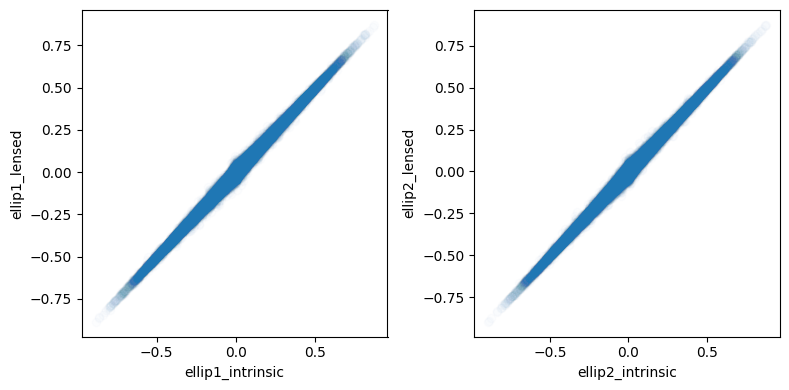

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
_ = ax[0].scatter(ellip1_intrinsic, ellip1_lensed, alpha = 0.01)
_ = ax[0].set_xlabel('ellip1_intrinsic')
_ = ax[0].set_ylabel('ellip1_lensed')
_ = ax[1].scatter(ellip2_intrinsic, ellip2_lensed, alpha = 0.01)
_ = ax[1].set_xlabel('ellip2_intrinsic')
_ = ax[1].set_ylabel('ellip2_lensed')
fig.tight_layout()

And finally, we confirm that as the magnitude of shear increases, the absolute difference between the lensed and unlensed ellipticities also tends to increase:

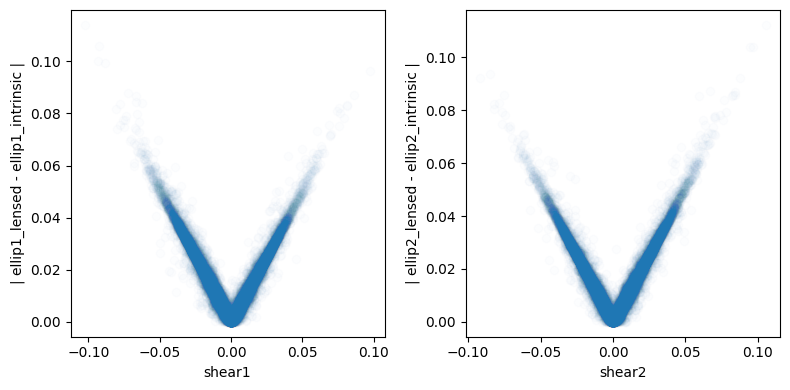

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
_ = ax[0].scatter(shear1, (ellip1_lensed - ellip1_intrinsic).abs(), alpha = 0.01)
_ = ax[0].set_xlabel('shear1')
_ = ax[0].set_ylabel('| ellip1_lensed - ellip1_intrinsic |')
_ = ax[1].scatter(shear2, (ellip2_lensed - ellip2_intrinsic).abs(), alpha = 0.01)
_ = ax[1].set_xlabel('shear2')
_ = ax[1].set_ylabel('| ellip2_lensed - ellip2_intrinsic |')
fig.tight_layout()

---

Our ground truth shear maps for DC2 are 8x8 grids of 256x256 pixel tiles, where the value of shear1 (or shear2) in each tile is the average shear1 (or shear2) of galaxies in that tile.

As a baseline estimator for the average shear in each tile $T$, we compute a weighted average of the lensed ellipticities in tile $T$ and some number of adjacent tiles. To compute this weighted average, we apply a Gaussian kernel with size $s$ and standard deviation $\sigma$. We've implemented this estimator in `case_studies/weak_lensing/utils/weighted_avg_ellip.py`.

Below, we tune $s$ and $\sigma$ by trying out several combinations and computing the resulting MSEs for shear1 and shear2.

In [9]:
import os
from hydra import initialize, compose
from hydra.utils import instantiate

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv
from bliss.surveys.dc2 import DC2DataModule
from case_studies.weak_lensing.utils.weighted_avg_ellip import compute_weighted_avg_ellip

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [10]:
ckpt = "/data/scratch/twhit/checkpoints/trained_encoder_dc2.ckpt"

with initialize(config_path="../../", version_base=None):
    cfg = compose("lensing_config_dc2", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed
GlobalEnv.current_encoder_epoch = 0

Seed set to 123123


In [11]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("fit")
train_dl = data_source.train_dataloader()

In [12]:
train_data = []
for batch in train_dl:
    train_data.append(batch)

When the kernel size is 1, the estimator just computes the average ellipticity of galaxies in tile $T$ and does not use any of the surrounding tiles.

When the kernel size is 15, the estimator uses the ellipiticities of the galaxies in all 8x8 tiles to compute its shear estimate in every tile $T$, even if tile $T$ is a corner tile.

In [13]:
kernel_sizes = [1,3,5,7,9,11,13,15]
kernel_sigmas = [1,3,5,7,9,11,13,15]

In [14]:
num_batches = len(train_data)

shear1 = torch.zeros(num_batches, 64)
shear2 = torch.zeros(num_batches, 64)
ellip1 = torch.zeros(len(kernel_sizes), len(kernel_sigmas), num_batches, 64)
ellip2 = torch.zeros(len(kernel_sizes), len(kernel_sigmas), num_batches, 64)
mse1 = torch.zeros(len(kernel_sizes), len(kernel_sigmas))
corr1 = torch.zeros(len(kernel_sizes), len(kernel_sigmas))
mse2 = torch.zeros(len(kernel_sizes), len(kernel_sigmas))
corr2 = torch.zeros(len(kernel_sizes), len(kernel_sigmas))

In [15]:
for j in range(len(kernel_sizes)):
    for k in range(len(kernel_sigmas)):
        print(f'kernel size = {kernel_sizes[j]}, kernel sigma = {kernel_sigmas[k]}')
        
        for i in range(num_batches):
            tile_cat = DC2DataModule.squeeze_tile_dict(train_data[i]['tile_catalog'])
            
            shear1[i] = tile_cat['shear_1'].flatten()
            shear2[i] = tile_cat['shear_2'].flatten()
            
            ellip_lsst_wavg = compute_weighted_avg_ellip(tile_cat, kernel_size = kernel_sizes[j], kernel_sigma = kernel_sigmas[k])

            ellip1[j,k,i] = ellip_lsst_wavg[...,0].flatten()
            ellip2[j,k,i] = ellip_lsst_wavg[...,1].flatten()
        
        mse1[j,k] = ((ellip1[j,k] - shear1)**2).mean()
        corr1[j,k] = np.corrcoef(ellip1[j,k].flatten(), shear1.flatten())[1,0]
        mse2[j,k] = ((ellip2[j,k] - shear2)**2).mean()
        corr2[j,k] = np.corrcoef(ellip2[j,k].flatten(), shear2.flatten())[1,0]
        
        print(f'MSE for shear 1 = {mse1[j,k]}')
        print(f'corr coef for shear 1 = {corr1[j,k]}')
        print(f'MSE for shear 2 = {mse2[j,k]}')
        print(f'corr coef for shear 2 = {corr2[j,k]}\n')

kernel size = 1, kernel sigma = 1
MSE for shear 1 = 0.000394217437133193
corr coef for shear 1 = -0.008347924798727036
MSE for shear 2 = 0.00038401316851377487
corr coef for shear 2 = -0.005224714521318674

kernel size = 1, kernel sigma = 3
MSE for shear 1 = 0.000394217437133193
corr coef for shear 1 = -0.008347924798727036
MSE for shear 2 = 0.00038401316851377487
corr coef for shear 2 = -0.005224714521318674

kernel size = 1, kernel sigma = 5
MSE for shear 1 = 0.000394217437133193
corr coef for shear 1 = -0.008347924798727036
MSE for shear 2 = 0.00038401316851377487
corr coef for shear 2 = -0.005224714521318674

kernel size = 1, kernel sigma = 7
MSE for shear 1 = 0.000394217437133193
corr coef for shear 1 = -0.008347924798727036
MSE for shear 2 = 0.00038401316851377487
corr coef for shear 2 = -0.005224714521318674

kernel size = 1, kernel sigma = 9
MSE for shear 1 = 0.000394217437133193
corr coef for shear 1 = -0.008347924798727036
MSE for shear 2 = 0.00038401316851377487
corr coef fo

We plot the MSE for each kernel size and standard deviation. For both shear1 and shear2, we find that a larger kernel size is better and that the kernel standard deviation does not matter too much as long as it is at least 2.

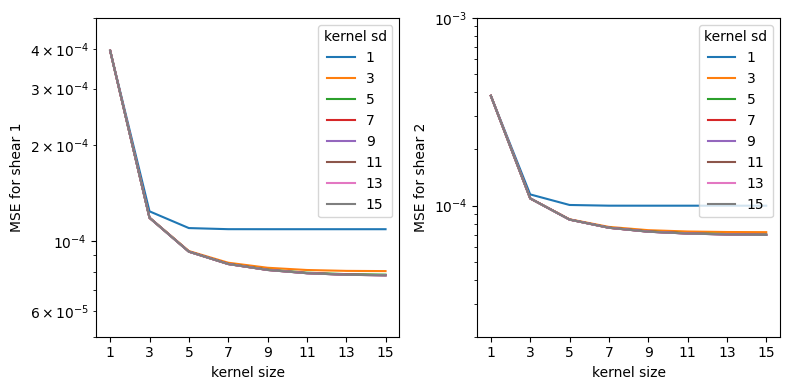

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

_ = ax[0].plot(mse1)
_ = ax[0].set_ylim((5e-5,5e-4))
_ = ax[0].legend(kernel_sigmas, title = 'kernel sd')
_ = ax[0].set_xticks(ticks = torch.arange(8), labels=kernel_sizes)
_ = ax[0].set_xlabel('kernel size')
_ = ax[0].set_ylabel('MSE for shear 1')
_ = ax[0].set_yscale('log')

_ = ax[1].plot(mse2)
_ = ax[1].set_ylim((2e-5,1e-3))
_ = ax[1].legend(kernel_sigmas, title = 'kernel sd')
_ = ax[1].set_xticks(ticks = torch.arange(8), labels=kernel_sizes)
_ = ax[1].set_xlabel('kernel size')
_ = ax[1].set_ylabel('MSE for shear 2')
_ = ax[1].set_yscale('log')

fig.tight_layout()

We select the optimal kernel size and standard deviation based on $R^2$. We take the average of the $R^2$ for the estimated shear1 and the $R^2$ for the estimated shear2.

Based on this metric, we conclude that the optimal kernel size and kernel standard deviation are both 15.

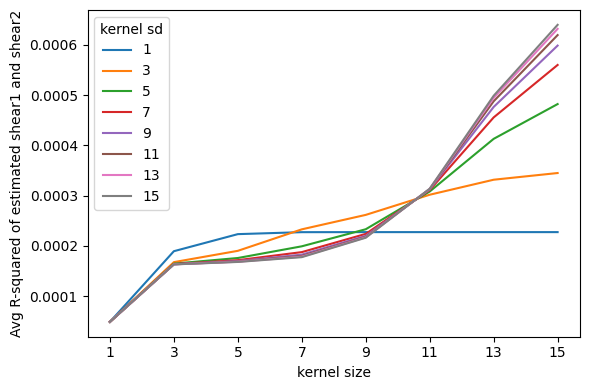

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

_ = ax.plot(0.5 * (corr1**2) + 0.5 * (corr2**2))
_ = ax.legend(kernel_sigmas, title = 'kernel sd')
_ = ax.set_xticks(ticks = torch.arange(8), labels=kernel_sizes)
_ = ax.set_xlabel('kernel size')
_ = ax.set_ylabel('Avg R-squared of estimated shear1 and shear2')

fig.tight_layout()

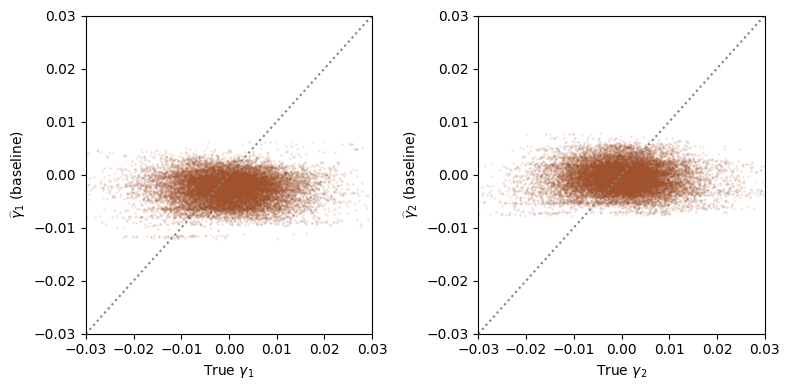

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
_ = ax[0].scatter(shear1.flatten(), ellip1[7,2].flatten(), s = 1, alpha = 0.1, color = "sienna")
_ = ax[0].set_xlim((-0.03, 0.03))
_ = ax[0].set_ylim((-0.03, 0.03))
_ = ax[0].set_xlabel(r'True $\gamma_1$')
_ = ax[0].set_ylabel(r'$\widehat{\gamma}_1$ (baseline)')
_ = ax[0].axline((0,0), slope = 1, linestyle = ':', color = 'gray')
_ = ax[1].scatter(shear2.flatten(), ellip2[7,2].flatten(), s = 1, alpha = 0.1, color = "sienna")
_ = ax[1].set_xlim((-0.03, 0.03))
_ = ax[1].set_ylim((-0.03, 0.03))
_ = ax[1].set_xlabel(r'True $\gamma_2$')
_ = ax[1].set_ylabel(r'$\widehat{\gamma}_2$ (baseline)')
_ = ax[1].axline((0,0), slope = 1, linestyle = ':', color = 'gray')
fig.tight_layout()